In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from peakutils import indexes

In [2]:
fn = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/videos/Image44.lsm'
lsm = tifffile.imread(fn)[0][0]

NameError: name 'tifffile' is not defined

In [3]:
cv2.imshow('slice',lsm[0])
#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0) 
#closing all open windows 
cv2.destroyAllWindows() 
# Select ROI
fromCenter = False
showCrosshair = False
seleted_parameters = cv2.selectROI(image, fromCenter, showCrosshair)
# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0]) 
y_end = y_start + int(seleted_parameters[2])
for i in lsm:


SyntaxError: unexpected EOF while parsing (<ipython-input-3-83170de3d961>, line 16)

In [4]:
MIN_POSITIONS_OUT_OF_BOUND = "The min_peaks_positions are not indexes of the intensities parameter"

MAX_POSITIONS_OUT_OF_BOUND = "The max_peaks_positions are not indexes of the intensities parameter"

EMPTY_INTENSITIES = "The intensities cannot be empty"
BAD_MAX_AND_MIN_LENGTHS = "The min peaks list needs to be bigger by 1 elements than the max peaks list"
MIN_PEAKS_ARE_REQUIRED = "At least 1 min peak is required"
MAX_PEAKS_ARE_REQUIRED = "At least 1 max peak is required"

def calculate_peaks(vector, min_dist_between_max_peaks):
    max_peaks = _max_peaks_positions(vector, min_dist_between_max_peaks)
    min_peaks = _min_peaks_positions(vector, max_peaks)

    return max_peaks, min_peaks


def _max_peaks_positions(vector, min_dist_between_max_peaks):
    threshold = 1.0 / max(vector) if (max(vector) > 0) else 0
    possible_max_peaks = indexes(np.array(vector), thres=threshold, min_dist=min_dist_between_max_peaks)
    intensity_avg = sum(vector) / len(vector)
    max_peaks = [max_peak for max_peak in possible_max_peaks if vector[max_peak] > intensity_avg/8]

    if len(max_peaks) == 0: raise ValueError("Peaks not found")

    return max_peaks


# For the calculation of minimum peaks we need at least 1 maximum peak

def _min_peaks_positions(intensities, max_peaks):
    minimums = []
    last_max = 0
    for max_index in max_peaks:
        minimums.append(minimo_bl(intensities[last_max:max_index]) + last_max)
        last_max = max_index

    minimums.append(minimo_bl(intensities[last_max:len(intensities)]) + last_max)

    return minimums


def minimo_bl (vector):
    b = -min((x, -i) for i, x in enumerate(vector))[1]
    return b

def _maxs_mins_input_validation(max_peaks, min_peaks):
    assert len(max_peaks) > 0, MAX_PEAKS_ARE_REQUIRED
    assert len(min_peaks) > 0, MIN_PEAKS_ARE_REQUIRED
    assert len(min_peaks) - len(max_peaks) == 1, BAD_MAX_AND_MIN_LENGTHS


def _intensities_validations(intensities, max_peaks_positions, min_peaks_positions):
    intensities_length = len(intensities)
    max_max_peak = max(max_peaks_positions)
    min_max_peak = min(max_peaks_positions)
    max_min_peak = max(min_peaks_positions)
    min_min_peak = min(min_peaks_positions)

    assert intensities_length > 0, EMPTY_INTENSITIES
    assert max_max_peak < intensities_length, MAX_POSITIONS_OUT_OF_BOUND
    assert max_min_peak < intensities_length, MIN_POSITIONS_OUT_OF_BOUND
    assert min_max_peak >= 0, MAX_POSITIONS_OUT_OF_BOUND
    assert min_min_peak >= 0, MIN_POSITIONS_OUT_OF_BOUND


def calculate_amplitudes(max_peaks_intensities, min_peaks_intensities):
    _maxs_mins_input_validation(max_peaks_intensities, min_peaks_intensities)

    amplitudes = []
    for i in range(0, len(min_peaks_intensities) - 1):
        amplitude = (max_peaks_intensities[i] - min_peaks_intensities[i]) / min_peaks_intensities[i]
        amplitudes.append(amplitude)
    return amplitudes

def analyze_image(image, min_dist_between_max_peaks, calibration, slice_width=0):
    image_analysis = _analyze_matrix(image, min_dist_between_max_peaks, calibration)
    slices_analysis = [_analyze_matrix_slice(matrix, min_dist_between_max_peaks, image_analysis, calibration) for matrix in
                       split_vertically_by(image, slice_width)] if slice_width > 0 else []

    return ({
        "image": image_analysis,
        "slices": slices_analysis
    })


def _analyze_matrix(matrix, min_dist_between_max_peaks, calibration):
    intensities = np.asarray(_mean_columns(matrix), dtype=np.int16)
    (max_peaks_positions, min_peaks_positions) = calculate_peaks(intensities, min_dist_between_max_peaks)
    max_peaks_intensities = _intensities_in_positions(intensities, max_peaks_positions)
    min_peaks_intensities = _intensities_in_positions(intensities, min_peaks_positions)

    return ({
        "intensities": intensities,
        "max_peaks_positions": max_peaks_positions,
        "max_peaks_intensities": max_peaks_intensities,
        "min_peaks_positions": min_peaks_positions,
        "min_peaks_intensities": min_peaks_intensities,
        "amplitudes": calculate_amplitudes(max_peaks_intensities, min_peaks_intensities),
    })

def _analyze_matrix_slice(matrix, min_dist_between_max_peaks,result,calibration):
    intensities = np.asarray(_mean_columns(matrix), dtype=np.int16)
    (max_peaks_positions, min_peaks_positions) = calculate_peaks_slice(result, min_dist_between_max_peaks,intensities)
    max_peaks_intensities = _intensities_in_positions(intensities, max_peaks_positions)
    min_peaks_intensities = _intensities_in_positions(intensities, min_peaks_positions)

    return ({
        "intensities": intensities,
        "max_peaks_positions": max_peaks_positions,
        "max_peaks_intensities": max_peaks_intensities,
        "min_peaks_positions": min_peaks_positions,
        "min_peaks_intensities": min_peaks_intensities,
        "amplitudes": calculate_amplitudes(max_peaks_intensities, min_peaks_intensities),

    })

def _mean_columns(slice):
    return np.asarray([float(np.mean(row)) for row in slice])


def _intensities_in_positions(intensities, positions):
    return [intensities[position] for position in positions]


In [72]:
def calculate_alternance_ratio(amp_df):
    '''Alternance Ratio (AR) was calculated as the difference in the magnitude of the two consecutive local transients / the amplitude of the largest transient.
'transients' parameter corresponds to 'calculate_AR' output.
The output is a list of AR'''
    AR_list = []
    for transient_amp in range(len(amp_df)-1):
        df = pd.DataFrame((amp_df.T[transient_amp],amp_df.T[transient_amp+1])).T
        AR = (abs(amp_df.T[transient_amp]-amp_df.T[transient_amp+1]))/df.max(axis=1)
        AR_list.append(AR)
    return AR_list

def discordance_index(local_AR_df):
    '''The discordance index (DI) is defined as the standard deviation of the measured local AR values.
    Input is 'calculate_alternance_ratio' of local AR output
    Output is a list od DI'''
    return local_AR_df.std().to_list()

In [73]:
def video_data_parse(video_data, dist_min_peak):
    df_amp = pd.DataFrame()
    for i in range(int((len(video_data.columns)-1)/6)-1):
        try:
            plt.plot(video_data['Mean'+str(i+1)])
            amplitudes = _analyze_matrix(video_data['Mean'+str(i+1)], dist_min_peak, 1)['amplitudes']
            df_amp[i] = amplitudes
        except:
            pass
    local_AR_df = pd.DataFrame(calculate_alternance_ratio(df_amp)).T
    return discordance_index(local_AR_df)

Image47.csv
[0.1490284428444128, 0.11657624510658997, 0.13210804893544106, 0.12585069852875963, 0.10577484863034765, 0.09772601007527845, 0.11759923188663159, 0.13261137870709053, 0.13809288315499998, 0.15261133476521882, 0.13761967325988908, 0.12465449115618768, 0.13092456104792746, 0.10126667614064343, 0.12781526075871127, 0.1519154575301359, 0.11998391847565858, 0.1725377119673087]
Image43.csv
[0.14365569964688535, 0.09992658975229017, 0.09401796341023576, 0.11067431815448747, 0.13162000153078726, 0.1262206125010007, 0.13985028435130567, 0.11608915852973033, 0.11939107710739998, 0.11433471875706985, 0.13310767049650019, 0.14216892211160942, 0.1242198554609767, 0.09419172135528456, 0.06358944461490038, 0.0824120084161631, 0.13372017998711622]
Image37.csv
[0.2618897479680439, 0.20509725139990012, 0.1393048447874839, 0.21755503460275644, 0.1782270228442489, 0.2449486879801238, 0.16408221300095277, 0.11515074884479877, 0.19770872559615107, 0.20741273477964853, 0.1768442888047495, 0.2079

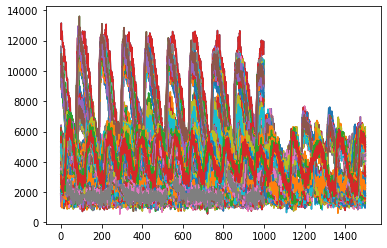

In [111]:
import os

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/videos/37/5Hz/'
df = pd.DataFrame()
for file in os.listdir(path):
    if 'csv' in file:
        print(file)
        video_data = pd.read_csv(path + file)
        print(video_data_parse(video_data, 40))
        df1 = pd.DataFrame(video_data_parse(video_data, 40),columns = [file[:-4]])
        df = pd.concat([df,df1], ignore_index=False, axis=1)

In [110]:
df.to_csv(path+'DIgradient_37_1hz')

In [109]:
df

,Image44,Image46,Image50,Image38,Image30,Image42,Image52,Image58,Image48,Image40
0,0.135843,0.071960,0.121416,0.120748,0.126507,0.089394,0.072965,0.043612,0.055937,0.114521
1,0.117949,0.099467,0.113017,0.086081,0.073740,0.067023,0.074497,0.070955,0.080886,0.109231
2,0.120018,0.108406,0.127329,0.104903,0.081925,0.088651,0.083346,0.051607,0.065217,0.083737
3,NaN,NaN,NaN,NaN,0.145327,NaN,NaN,0.056053,0.059427,NaN
4,NaN,NaN,NaN,NaN,0.121249,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,0.240616,NaN,NaN,NaN,NaN,NaN
